Ordinary Least-Squares in 1-D and N-D
====

## Unit 12, Lecture 1

*Numerical Methods and Statistics*

----

### Reading

Bulmer: Chapter 12 (Regression & Correlation)

----


#### Prof. Andrew White, April 12 2018

Goals:
---

1. Understand the nomenclature of the regression equation and terms
2. Be able to recognize which terms represent noise and which are model terms
3. Perform linear regression in 1 or more dimensions
4. Be able to construct probability distributions representing parameter uncertainty
5. Compute hypothesis tests and confidence intervals

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, erf
import scipy.stats

Least Squares Linear Regression
====

Let's define the problem setting for linear regression.

We have some data, $x$ and $y$, and we want to fit a line to the data. Our model will be:

$$\hat{y} = \hat{\alpha} + \hat{\beta}x$$

where a $\hat{}$ indicates our best estimate of something. We make an assumption that the process that generates our data looks like:

$$y = \alpha + \beta x + \epsilon$$

where $\epsilon$ is coming from a normal distribution

Nomenclature
-----

* $\alpha$ - an intercept
* $\hat{\alpha}$ - our estimated best intercept
* $\beta$ - a slope
* $\hat{\beta}$ - our estimated best slope
* $\hat{y}$ - our estimated y's
* $\epsilon$ - the variable which is creating normally distributed noise.
* $x,y$ - the data
* Residual - the difference between $\hat{y}$ and $y$ at a particular point ($\hat{y}_i - y_i$)
* Sum of squared residues (SSR) - $\sum_i (\hat{y}_i - y_i)^2$
* Sum of squared error (SSE) - the same as SSR
* Total sum of squares (TSS) - $\sum_i (\bar{y} - y_i)^2$, which is a kind of variance
* $S_{\textrm{something}}$ - The standard error of something

Linear Regression with Optimization - (Conceptual Example, do not ever do ordinary least squares like this)
====

One way to view this problem is as an optimization. Can we write down an equation that results in a single value that we minimize? Our ultimate goal is to make $\hat{y}$ as close as possible to $y$. Mathematically, that means we want $\sum_i(y_i - \hat{y}_i)^2$ to be small. 

That is the objective function to minimize, but what are the dimensions to change? Those are $\hat{\alpha}$ and $\hat{\beta}$. So we need to write down a function which takes in $\hat{\alpha}$ and $\hat{\beta}$ and returns how good the fit is:

$$f(\hat{\alpha}, \hat{\beta}) = \sum_i \left(y_i - \hat{\alpha} - \hat{\beta} x_i\right)^2$$

We can minimize this equation using any of our minimization techniques

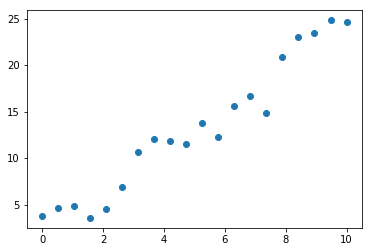

In [2]:
#Make some data -> this is problem setup

x = np.linspace(0,10, 20)
y = 1 + x * 2.5 + scipy.stats.norm.rvs(scale=2, size=20)
plt.plot(x,y, 'o')
plt.show()

In [3]:
#DO NOT COPY PASTE THIS FOR HW/TEST
#NOT CORRECT WAY TO DO 1D REGRESSION!
def SSR(arg):
    alpha = arg[0]
    beta = arg[1]
    yhat = alpha + beta * x
    ssr = np.sum((yhat - y)**2)
    return ssr

import scipy.optimize

result = scipy.optimize.minimize(SSR, x0=[1,1])
result

      fun: 53.79597327030814
 hess_inv: array([[ 0.09285715, -0.01357143],
       [-0.01357143,  0.00271429]])
      jac: array([ -9.53674316e-07,   1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 1.859828  ,  2.26867042])

1.85982800428 2.26867042487


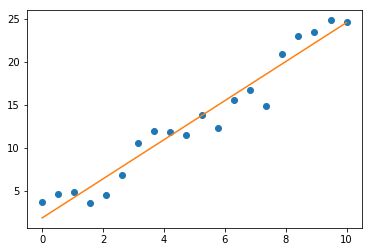

In [4]:
alpha_hat = result.x[0]
beta_hat = result.x[1]

print(alpha_hat, beta_hat)

plt.plot(x,y, 'o')
plt.plot(x, alpha_hat + beta_hat * x)
plt.show()


----
Notice that we didn't get exactly the correct answer. The points were generated with a slope of 2.5 and an intercept of 1, whereas our fit was a little bit off

Hypothesis Test for Normality
====

Another important hypothesis is determining if a sample is normally distributed. We said in class many times that we require things to be normal for many methods. Here's how we actually test that.

Shapiro–Wilk Test
====

**Data Type:** single group of samples

**Compares:** If the samples came from an unknown parent normal distribution (are they normally distributed)

**Null Hypothesis:** The samples are from the unknown parent normal distribution

**Conditions:** None

**Python:** `scipy.stats.shapiro`

**Notes:** There are many other tests for normality. This one is not the simplests, but is the most effective

In [5]:
data = [12.4, 12.6, 11.8, 11.5, 11.9, 12.2, 12.0, 12.1, 11.8]

scipy.stats.shapiro(data)

(0.9825882911682129, 0.9762559533119202)

The $p$-value is quite high, so we don't reject the null hypothesis

In [6]:
data = np.linspace(0,1, 100)

scipy.stats.shapiro(data)

(0.9547258019447327, 0.0017220161389559507)

The $p$-value is 0.002, so we correctly reject the null hypothesis

Linear Regression Assumption Check
=====

One of our assumptions was that the noise is normally distributed. Recall our model:

$$y = \alpha + \beta x + \epsilon$$
$$\epsilon = y - \alpha - \beta x \approx y - \hat{y}$$

Where the $\approx$ is because we are using our estimates for $\alpha$ and $\beta$. We can now check our assumption by histogramming the residuals, which should be the same as looking at the $\epsilon$ distribution.

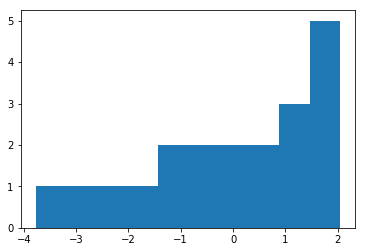

In [7]:
plt.hist(y - beta_hat * x - alpha_hat)
plt.show()

----

At this point, it's unclear if they are normally distributed. Luckily we just learned the Shapiro–Wilk Test!

In [8]:
scipy.stats.shapiro(y - beta_hat * x - alpha_hat)

(0.9274411797523499, 0.1378503441810608)

----
It looks like the residuals may indeed be normally distributed. So, our assumption was valid.

Linear Regression With Statistics &mdash; Ordinary Least Squares Regression in 1D (OLS-1D)
====

We have the same problem setting as above, but now we'll solve it using a different approach. Using calculus you can show from above that the minimum to $f(\alpha, \beta)$ above is:

$$\hat{\beta} = \frac{\sum_i(x_i - \bar{x})(y_i - \bar{y})}{\sum_i(x_i - \bar{x})^2}$$

With a little bit of algebra, you can show this is

$$\hat{\beta} = \frac{\sigma_{xy}}{\sigma_x^2}$$

where $\sigma_{xy}$ is the sample covariance of $x$ and $y$ and $\sigma_x^2$ is the sample variance of $x$.

To find the intercept, you can just take the average of the residuals (not their squares!) given the model so far:

$$\hat{\alpha} = \frac{1}{N}\sum_i (y_i - \hat{\beta}x_i)$$

Let's see this in action

In [9]:
#using the data from above

cov = np.cov(x,y, ddof=2)

#recall that the diagonal is variances, so we use that directly
beta_hat_2 = cov[0,1] / cov[0,0]

print (beta_hat, beta_hat_2)

alpha_hat_2 = np.mean( y - beta_hat_2 * x)

print(alpha_hat, alpha_hat_2)

2.26867042487 2.26867043583
1.85982800428 1.85982797326


----
As you can see, the results are identical. 

Linear Regression Goodness of Fit
====

There are a few ways of measuring goodness of fit. One way is to just compute the SSR, the sum of the squared residuals. However, this has the negative that the units of $y$ appear in the goodness of fit. Here is what people typically use, the coefficient of determination:

$$R^2 = 1 - \frac{\textrm{SSR}}{\textrm{TSS}} = 1 - \frac{\sum_i \left(\hat{y}_i - y\right)^2}{\sum_i \left(\bar{y} - y\right)^2}$$

This equation has the property that it's unitless, it's $1$ when the fit is perfect, and $0$ when the fit is awful. In the case of linear regression, $R$ is the same as the correlation coefficient.

In [10]:
ssr = np.sum((y - alpha_hat - beta_hat * x)**2)
tss = np.sum((np.mean(y) - y)**2)

rsq = 1 - ssr / tss

print(rsq, sqrt(rsq))
print(np.corrcoef(x,y))

0.946306194468 0.9727827067068469
[[ 1.          0.97278271]
 [ 0.97278271  1.        ]]


Linear Regression Error Analysis
=====

Knowing goodness of fit is not quite useful yet though. We'd like to do hypothesis tests, build confidence intervals, etc. We need to know how the $\hat{\beta}$ are distributed!

Standard Error
---

As you may have noticed, sometimes it gets confusing that the difference between the sample mean and the true mean, $\mu - \bar{x}$, are distributed according to a normal or $T$ distribution if the samples are distributed according to a normal distribution. Thus we end up with two distributions: one with parameters $\mu$, $\sigma$ that describes the samples and one with parameters $\mu$, $\sigma / \sqrt{N}$ that describes the difference between sample mean and true mean. Often this $\sigma / \sqrt{N}$ term is called **Standard Error** to distinguish it from the standard deviation of the population (true/hidden) distribution. Thus you can write:

$$T = \frac{\bar{x} - \mu}{\sigma_x / \sqrt{N}} = \frac{\bar{x} - \mu}{S} $$

We're going to start using **Standard Error** now. You then can use **Standard Error** in confidence intervals or hypothesis tests. The same rules as previously apply: $N < 25$ requires a $t$-distribution and above is normal.

One other important thing to remember is that the denominator in the standard error should be the square root of the degrees of freedom. Usually this is written as $N - D$, where $D$ is the deducted degrees of freedom. In the case of linear regression, we have $D$ being the number of coefficients we're fitting. That $N - D$ is also the degrees of freedom in the $t$-distribution. 

Error Equation for OLS-1D
---

You may read the derivation in Bulmer on page 226. The variance in our estimated values ($S^2$) for slope and intercept are:

$$S^2_{\epsilon} =\frac{\sigma^2_{\epsilon}}{N - D} =  \frac{1}{N - D}\sum_i \left(\hat{y}_i - y_i\right)^2$$

$$S^2_{\alpha} = S^2_{\epsilon} \left[ \frac{1}{N - D} + \frac{\bar{x}^2}{\sum_i\left(x_i - \bar{x}\right)^2}\right]$$

$$S^2_{\beta} = \frac{S^2_{\epsilon}}{\sum_i \left(x_i - \bar{x}\right)^2}$$

$D$ here is the number of fit coefficients. 2 in our case.

Example: Compute the standard error of the intercept and create a probability distribution for the true intercept
----

We'll continue using the data from above

In [11]:
df = len(x) - 2
s2_epsilon = np.sum((y - alpha_hat - beta_hat * x) ** 2) / df
s2_alpha =  s2_epsilon * (1. / df + np.mean(x) ** 2 / (np.sum((np.mean(x) - x) ** 2)))

print('The standard error for the intercept is', np.sqrt(s2_alpha))

The standard error for the intercept is 0.756069781772


Let's just visualize now what the distribution for where the true intercept looks like. We know it is distributed according to:

$$P(\alpha) = T(\mu=\hat{\alpha}, \sigma=S_\alpha, df=18)$$

The degrees of freedom here is 

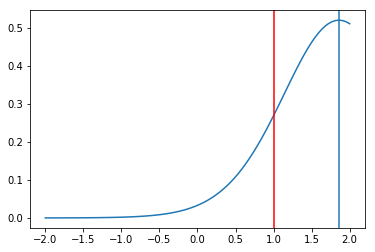

In [12]:
alpha_grid = np.linspace(-2, 2, 100)
P_alpha = scipy.stats.t.pdf(alpha_grid, loc=alpha_hat,  scale=np.sqrt(s2_alpha), df=len(x) - 2)

plt.plot(alpha_grid, P_alpha)
plt.axvline(1, color='red')
plt.axvline(alpha_hat)
plt.show()

Example: Construct a 95% confidence interval for the slope
---

Once we compute $S_\beta$, we can use the formulas we've seen before:

$$P(\beta = \hat{\beta} \pm y) = 0.95$$

$$T = \frac{y}{S_\beta}$$

$$y = TS_\beta$$

The confidence interval will then be:

$$\beta = \hat{\beta} \pm TS_\beta$$ with 95% confidence

In [13]:
s2_beta = s2_epsilon / np.sum((x - np.mean(x))**2)
T = scipy.stats.t.ppf(0.975, len(x) - 2)

print(s2_beta, T)

print('beta = ', beta_hat, '+/-', T * np.sqrt(s2_beta), ' with 95% confidence')

0.0162241824149 2.10092204024
beta =  2.26867042487 +/- 0.267603227762  with 95% confidence


Notice that just like in confidence intervals, once $N$ becomes large we can replace the $t$-distribution with a normal distribution.

The next interesting consequence of the $t$-distribution is that we can construct a hypothesis test. For example, we could test if the intercept should be $0$.

Example: A hypothesis test for the existence of an intercept
---

Our null hypothesis is that the intercept is $0$. Then, we can compute how big an interval would have to be constructed around $0$ to just capture what we calculated for $\alpha$. The distribution for that interval is:

$$P(\alpha) = T(\mu=0, \sigma=S_\alpha, df=N - D = 19)$$

We take $D = 1$ here because we work under the assumption of the null hpyothesis (i.e., only slope needs to be fit). For the actual regression analysis, you should still use $D = 2$. Only when you do the hypothesis test itself do you use the $D = 1$

To convert to a standard $t$-distribution (variance is 1), so we have:

$$T = \frac{\hat{\alpha}}{S_\alpha}$$

$$\int_{-T}^T p(T)\,dT = 1 - p$$

In [14]:
df = len(x) - 2
s2_epsilon = np.sum((y - alpha_hat - beta_hat * x) ** 2) / df
s2_alpha =  s2_epsilon * (1. / df + np.mean(x) ** 2 / (np.sum((np.mean(x) - x) ** 2)))
#ensure our T-value is positive, so our integral doesn't get flipped
T = abs(alpha_hat / sqrt(s2_alpha))
p = 1 - (scipy.stats.t.cdf(T, len(x) - 1) - scipy.stats.t.cdf(-T, len(x) - 1))
print('alpha = ', alpha_hat, ' T = ', T, ' p-value = ', p)

alpha =  1.85982800428  T =  2.45986289774  p-value =  0.0236547622333


---

*Depends on random date above!*

When I ran this, the $p$-value is $\approx 0.04$ which says the evidence is weak but we can reject the null hypothesis. There is an intercept, since the $p$-value is below our threshold of 5%.

Extending Least-Squares to Multiple Dimensions in Domain - OLS-ND
====

Our governing equation is now:


$$y = {\mathbf X\beta} + \epsilon$$

where $\mathbf X$ is an $N\times D$ matrix, where $N$ is the number of data points and $D$ is the number of dimensions. $\beta$ is then a $D$ length column vector. We want to find $\hat{\beta}$ and get a model that looks like:

$$\hat{y} = {\mathbf X\hat{\beta}}$$

This can be done with optimization just like last time, but we can more easily do it with matrix algebra. The equation for $\hat{\beta}$ is:


$$\hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^Ty$$

Example
---

Let's try to fit the equation:

$$ y = 3 + 3 x_1 + x_2 + \epsilon$$

with 

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

In [15]:
#NOTE: THIS IS NOT PART OF REGRESSION!!!!
#DO NOT COPY PASTE THIS CODE INTO HW/EXAM
#generate data
#I add some noise to the x coordinate to just spread the points out a little.
x1 = np.linspace(0,1,15)+ scipy.stats.norm.rvs(size=15)
x2 = np.linspace(0,1,15) + scipy.stats.norm.rvs(size=len(x1))
y = 3 * x1 - 2 * x2 + 3 + scipy.stats.norm.rvs(size=len(x1))
y

array([  6.34553969,   5.56960193,   5.54041598,  -6.37636452,
         6.75769394,   0.18183426,   4.38860988,  11.44543952,
         8.63328974,   3.47046163,   4.83577384,   9.73218027,
         6.62614668,   4.07787342,   1.3511508 ])

In [16]:
import numpy.linalg as linalg

x_mat = np.column_stack( (np.ones(len(x1)), x1, x2) )
x_mat

array([[ 1.        ,  0.70466649, -0.61410856],
       [ 1.        , -0.05608442, -1.71457365],
       [ 1.        ,  0.18273291, -1.01246413],
       [ 1.        , -3.13458626, -0.06285789],
       [ 1.        ,  1.33720324,  0.24250041],
       [ 1.        , -0.57642405,  0.46554903],
       [ 1.        ,  0.0987994 , -0.32367523],
       [ 1.        ,  1.68170523, -1.67808411],
       [ 1.        ,  1.94798082,  0.67044847],
       [ 1.        ,  0.38123134,  0.61437483],
       [ 1.        ,  1.17574986,  0.82090456],
       [ 1.        ,  0.47491963, -1.99326301],
       [ 1.        ,  2.3639667 ,  2.23266263],
       [ 1.        ,  0.18832357,  0.3864873 ],
       [ 1.        ,  0.72998953,  2.2985694 ]])

Now we have our $X$ matrix set-up. Now we need to evaluate the matrix equation for $\hat{\beta}$ above:

In [17]:
#dot -> matrix multiplication
#transpose -> take a transpose
#linalg.inv -> compute a matrix inverse
beta_hat = linalg.inv(x_mat.transpose() @ x_mat) @ x_mat.transpose() @ y

Since it is tedius to type that whole equation out, you can instead use a shortcut:

In [18]:
beta_hat, *_ = linalg.lstsq(x_mat, y)

The `*_` symbol means put the rest of the return value into the `_` variable, which recall is how we indicate that we're making a variable which we will not use.

Let's now see how well the regression did!

In [19]:
y_hat = x_mat @ beta_hat

The first plot will be a $\hat{y}$ vs $y$ plot. If they were the same, you would see a $y=x$ line. How far the deviation is from that line is how bad the fit is.

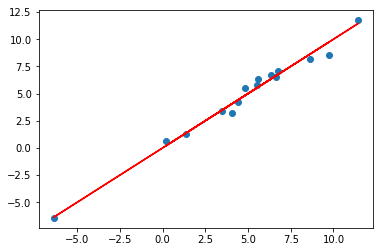

In [20]:
plt.plot(y, y_hat, 'o')
plt.plot(y, y, 'r')
plt.show()

Of course we can also look at the histogram of residuals

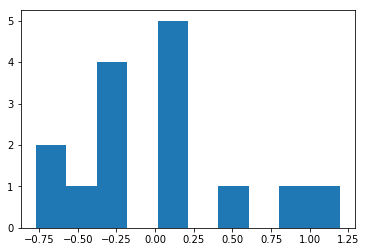

In [21]:
plt.hist(y - y_hat)
plt.show()

Error Analysis For Multidimensional Least Squares - OLS-ND
====

Just like before, if we can find the standard error for the noise/residual, $\epsilon$, then we can find everything else. The equation for that is:

$$S^2_{\epsilon} =\frac{\sigma^2_{\epsilon}}{N - D} =  \frac{1}{N - D}\sum_i \left(\hat{y}_i - y_i\right)^2$$

where $D$ is the dimension of $\beta$. Knowing that, the standard error for $\hat{\beta}$ is 

$$S^2_{\beta} = S^2_{\epsilon} \left(\mathbf{X}^T\mathbf{X}\right)^{-1}$$

where the diagonal elements are the standard errors. The off-diagonal elements are unrelated.

And again, $P(\beta - \hat{\beta}) \propto T(0, \sigma = S_\beta, df = N - D)$

The $N - D$ term is called the degrees of freedom. $D$ is the number of fit coefficients.

Transforming Problems into Multiple Domain Dimensions
====

One of the most common uses for this form of least-squares is if your problem is non-linear and you want to linearize it. For example, let's say I am in 1 dimension and the model I'd like to have is:

$$y = \beta_2 x^2 + \beta_1 x + \beta_0 + \epsilon$$

I can package that into a vector, like this: $[x^2, x, 1]$ and create an $\mathbf{X}$ matrix by creating a vector for each $x_i$. If my $x$ values are 1,2,3, that would like:

$$\left[ \begin{array}{lcr}
1^2 & 1 & 1\\
2^2 & 2 & 1\\
3^2 & 3 & 1\\
\end{array}\right]$$

Example: Linearizing a Polynomial for OLS-ND
----

In [22]:
#NOTE THIS IS NOT PART OF REGRESSION!
#make some data to regress
x = np.linspace(-3, 3, 25)
y = 2 * x ** 2 - 3 * x + 4 + scipy.stats.norm.rvs(size=len(x), loc=0, scale=1.5)
#END

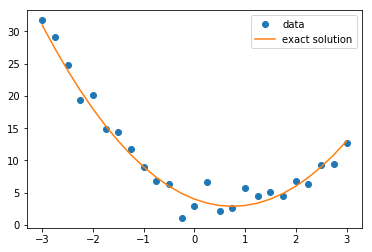

In [23]:
plt.plot(x,y, 'o', label='data')
plt.plot(x,2 * x ** 2 - 3 * x + 4, '-', label='exact solution')
plt.legend(loc='upper right')
plt.show()

In [24]:
x_mat = np.column_stack( (x**2, x, np.ones(len(x))) )
x_mat

array([[ 9.    , -3.    ,  1.    ],
       [ 7.5625, -2.75  ,  1.    ],
       [ 6.25  , -2.5   ,  1.    ],
       [ 5.0625, -2.25  ,  1.    ],
       [ 4.    , -2.    ,  1.    ],
       [ 3.0625, -1.75  ,  1.    ],
       [ 2.25  , -1.5   ,  1.    ],
       [ 1.5625, -1.25  ,  1.    ],
       [ 1.    , -1.    ,  1.    ],
       [ 0.5625, -0.75  ,  1.    ],
       [ 0.25  , -0.5   ,  1.    ],
       [ 0.0625, -0.25  ,  1.    ],
       [ 0.    ,  0.    ,  1.    ],
       [ 0.0625,  0.25  ,  1.    ],
       [ 0.25  ,  0.5   ,  1.    ],
       [ 0.5625,  0.75  ,  1.    ],
       [ 1.    ,  1.    ,  1.    ],
       [ 1.5625,  1.25  ,  1.    ],
       [ 2.25  ,  1.5   ,  1.    ],
       [ 3.0625,  1.75  ,  1.    ],
       [ 4.    ,  2.    ,  1.    ],
       [ 5.0625,  2.25  ,  1.    ],
       [ 6.25  ,  2.5   ,  1.    ],
       [ 7.5625,  2.75  ,  1.    ],
       [ 9.    ,  3.    ,  1.    ]])

[ 2.0141931  -3.12756944  4.18772416]


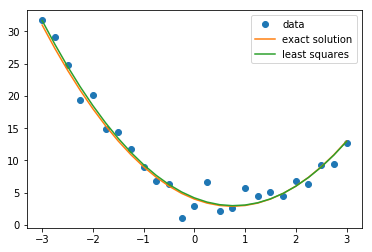

In [25]:
beta,*_ = linalg.lstsq(x_mat, y) 
print(beta)
plt.plot(x,y, 'o', label='data')
plt.plot(x,2 * x ** 2 - 3 * x + 4, '-', label='exact solution')
plt.plot(x,x_mat.dot(beta), label='least squares')
plt.legend(loc='upper right')
plt.show()


Example Error Analysis 
---

In [26]:
yhat = x_mat @ beta
resids = yhat - y
SSR = np.sum(resids**2)
se2_epsilon = SSR / (len(x) - len(beta))
print(se2_epsilon)

2.38360479975


In [27]:
se2_beta = se2_epsilon * linalg.inv(x_mat.transpose() @ x_mat)
print(se2_beta)

[[ 0.01133785  0.         -0.036848  ]
 [ 0.          0.02933667  0.        ]
 [-0.036848    0.          0.21510018]]


Now that we have the standard error matrix, we can create confidence intervals for the $\beta$ values.

In [28]:
for i in range(len(beta)):
    #get our T-value for the confidence interval
    T = scipy.stats.t.ppf(0.975, len(x) - len(beta)) 
    # Get the width of the confidence interval using our previously computed standard error
    cwidth = T * np.sqrt(se2_beta[i,i]) 
    # print the result, using 2 - i to match our numbering above
    print("beta_{} is {} +/- {} with 95% confidence".format(2 - i, beta[i], cwidth)) 

beta_2 is 2.014193099903578 +/- 0.22082459027469722 with 95% confidence
beta_1 is -3.1275694441732362 +/- 0.3552119865602704 with 95% confidence
beta_0 is 4.187724162346168 +/- 0.9618393942345842 with 95% confidence


Goodness of Fit
====

The same equations above apply here. For the example of the polynomial:

In [29]:
TSS = np.sum( (np.mean(y) - y)**2)
R2 = 1 - SSR / TSS
R2, np.sqrt(R2)

(0.96915547301563798, 0.98445694320048249)

The Statistics of Regression
===

You can justify a regression and its coefficients by:

1. A Spearmann correlation test
2. A Shapiro-Wilks normality test on residuals
3. A Goodness of fit

You can justify a particular **model** by:

1. Plotting
2. Hypothesis tests on individual coefficients

You CANNOT use a goodness of fit to compare models, since each time you add a new parameter you get a better fit

Conducting a good regression
===

You should do the following when you want to do a good job:

1. Justify correlation
2. Compute your model coefficients, their standard errors, confidence intervals, and p-values for existing
3. Plot your regressed model (use $y$ vs $\hat{y}$ for N-dimensions)
4. Histogram and compute Shapiro-Wilks normality test on residuals